In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config

from runner import run_vsem_experiment
from grid_utils import (
    coverage_curve_grid, 
    plot_hpd_weights_grid,
    plot_coverage,
)

import vsem_jax as vsem
from inverse_problem import InvProb, VSEMPrior, VSEMLikelihood
from surrogate import VSEMTest

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../helpers/")
from distribution_utils import (
        ClippedGaussian, 
        logscore_clipped_gaussian, 
        logscore_clipped_lognormal
)

sys.path.append("./../../helpers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

config.update("jax_enable_x64", True)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
sns.set_theme(style='white', palette='colorblind') # whitegrid
sns.set_context("paper", font_scale=1.5)

# Specific Paul Tol color scheme when comparing different posteriors
colors = {
    'exact': "#4477AA",
    'mean': "#EE6677",
    'eup': "#228833",
    'ep': "#CCBB44",
    'aux': "#888888"
}

In [ ]:
rng = np.random.default_rng(12421)
n_design = 15
design_method = 'lhc'
n_test_grid_1d = 50
n_reps = 5
clip = True

tests, metrics, metrics_clip, failed = run_vsem_experiment(rng=rng, 
                                                           n_design=n_design,
                                                           design_method=design_method,
                                                           n_reps=n_reps, 
                                                           n_test_grid_1d=n_test_grid_1d,
                                                           store_pred_clipped=clip)

Replication 1
Optimization terminated successfully.
         Current function value: 41.519247
         Iterations: 88
         Function evaluations: 100
         Gradient evaluations: 100
Replication 2


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 47.721765
         Iterations: 91
         Function evaluations: 151
         Gradient evaluations: 141
Replication 3
Optimization terminated successfully.
         Current function value: 67.673919
         Iterations: 87
         Function evaluations: 99
         Gradient evaluations: 99
Replication 4
Optimization terminated successfully.
         Current function value: 59.096703
         Iterations: 69
         Function evaluations: 75
         Gradient evaluations: 75
Replication 5
Optimization terminated successfully.
         Current function value: 68.329726
         Iterations: 87
         Function evaluations: 95
         Gradient evaluations: 95
Number of failed iterations: 0


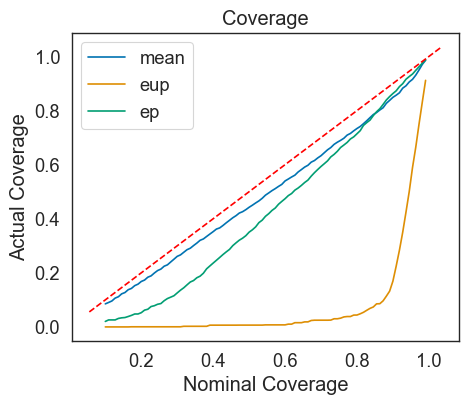

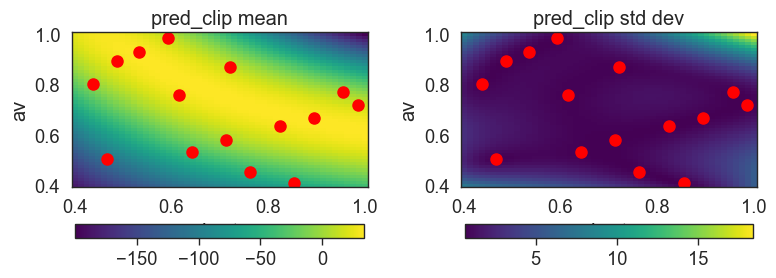

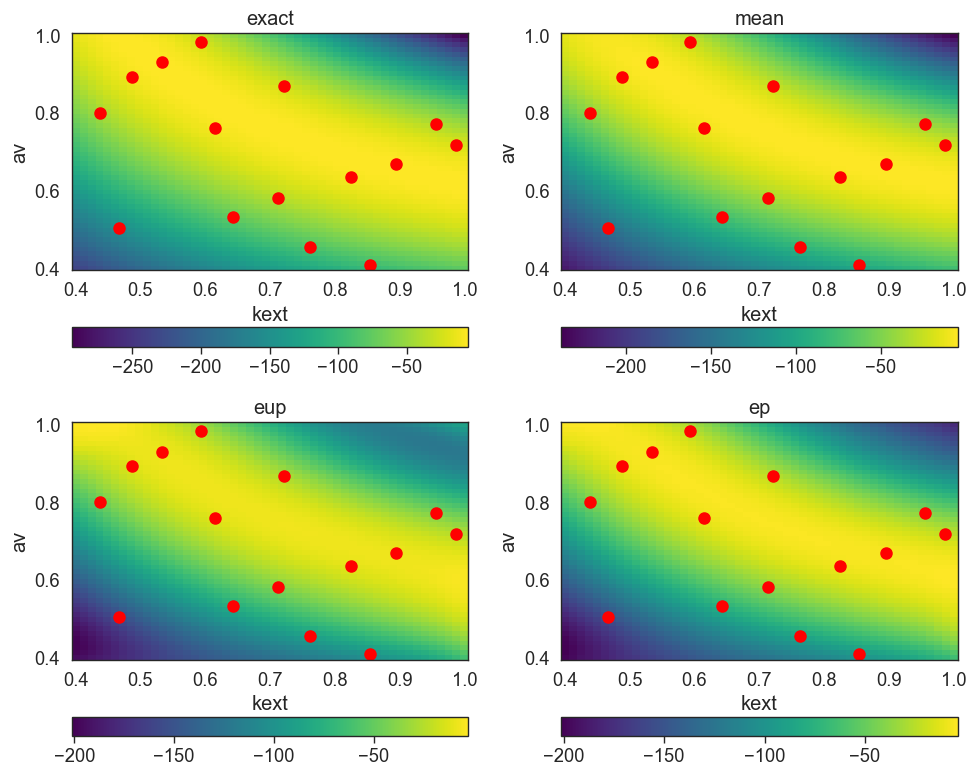

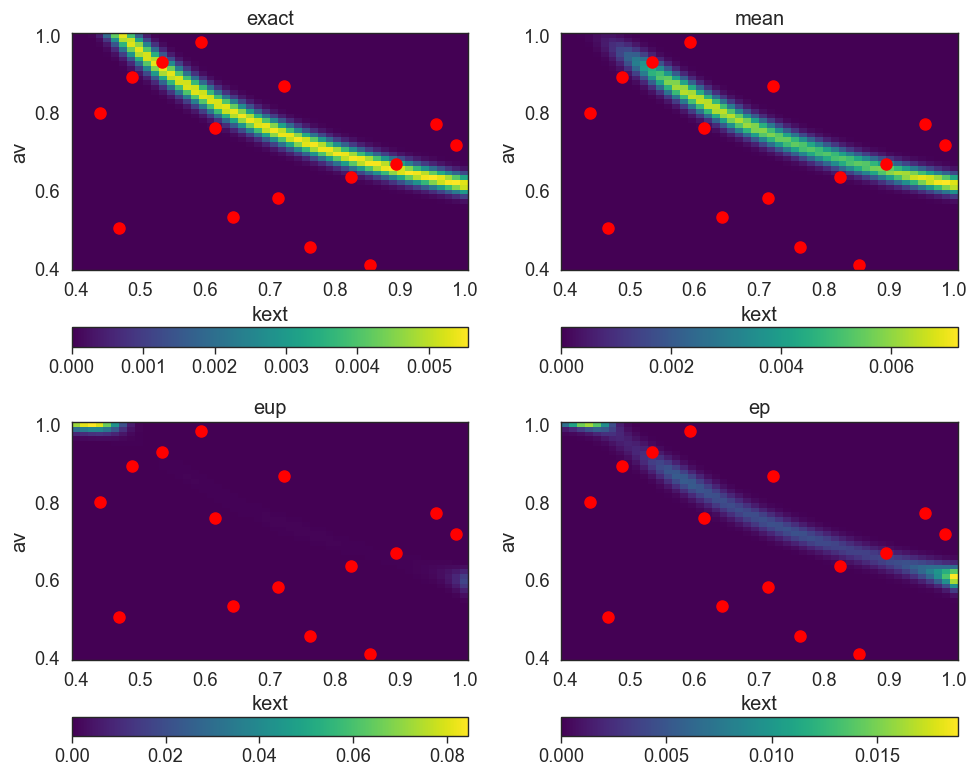

In [19]:
# summarize single replicate 
test_idx = 3
pred_label = 'pred_clip'
test = tests[test_idx]
metric = metrics_clip[test_idx] if pred_label=='pred_clip' else metrics[test_idx]

# coverage
probs = metric['coverage']['probs']
cover = metric['coverage']['cover']
cover_list = [cover[i] for i in range(cover.shape[0])]
labels = metric['coverage']['labels']
fig = plot_coverage(probs, cover_list, labels=labels)
display(fig)

# GP predictions
fig_gp, axs_gp = test.plot_gp_pred(conditional=True, pred_type=pred_label, markersize=8)
display(fig_gp)
plt.close()

# Comparing posteriors
fig_log, axs_log = test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                  pred_type=pred_label, nrows=2, figsize=(10,8))
fig, axs = test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                          pred_type=pred_label, nrows=2, figsize=(10,8))
display(fig_log)
display(fig)
plt.close()

/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_18580/4270057246.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


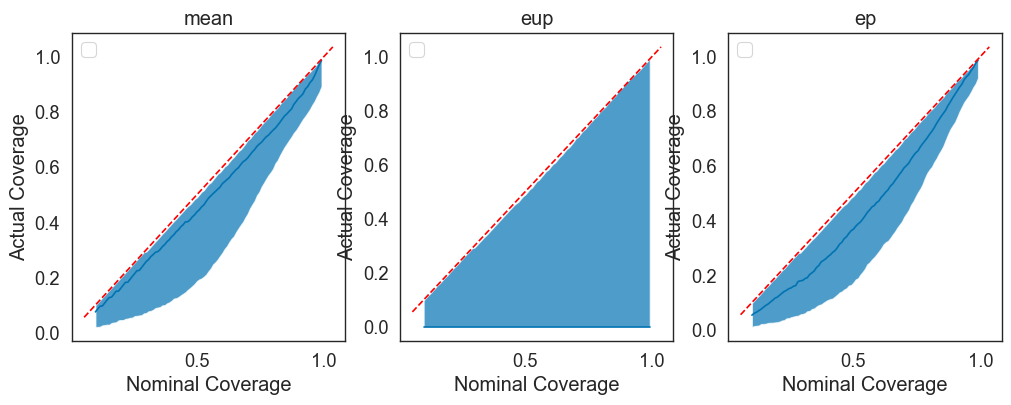

In [14]:
fig, ax = plot_coverage_distribution(tests, metrics, labels)
display(fig)